<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: NPL on Intermittent Fasting and Keto Diet

---

# Part 2

## Loading Dataset

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import string
import nltk
import re


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from gensim.parsing.preprocessing import remove_stopwords
from textblob import TextBlob

In [2]:
df = pd.read_csv('./data/subreddit_data.csv')

In [3]:
# Adding word count and status length for each subreddit data frame
def word_counts(df):
    df['post_word_count'] = [len(df['selftext'].iloc[i].split(' ')) for i, status in enumerate(df['selftext'])]
    df['post_length'] = [len(df['selftext'].iloc[i]) for i, status in enumerate(df['selftext'])]
    return df

df = word_counts(df)

In [4]:
df.head()

,Unnamed: 0,title,selftext,subreddit,created_utc,post_word_count,post_length
0,0,Plateau sruggles,I (27F) have been intermittent fasting for abo...,intermittentfasting,1625589667,123,660
1,4,Can I still do IF/OMAD now that I started exer...,"I started lifting 4x/week (about 40 minutes), ...",intermittentfasting,1625586042,127,679
2,5,A new mindset,"Hello everyone,\n\n I am a mostly lurker here...",intermittentfasting,1625584307,182,929
3,6,Weekend habits are making it difficult to loos...,"Hi everyone,\n\nI have been doing IF (16:8) fo...",intermittentfasting,1625582039,110,569
4,7,Are these times acceptable for IF?,"So, due to loss of employment, family has take...",intermittentfasting,1625582007,167,806


In [5]:
# Check for null values
df.isnull().sum()

Unnamed: 0         0
title              0
selftext           0
subreddit          0
created_utc        0
post_word_count    0
post_length        0
dtype: int64

In [6]:
df.drop(columns = 'Unnamed: 0',inplace = True)

In [7]:
df.shape

(10290, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10290 entries, 0 to 10289
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            10290 non-null  object
 1   selftext         10290 non-null  object
 2   subreddit        10290 non-null  object
 3   created_utc      10290 non-null  int64 
 4   post_word_count  10290 non-null  int64 
 5   post_length      10290 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 482.5+ KB


## EDA

In [9]:
df['subreddit'].value_counts(normalize = True)

keto                   0.544412
intermittentfasting    0.455588
Name: subreddit, dtype: float64

In [10]:
df['subreddit'] = df['subreddit'].map({'keto':1,'intermittentfasting':0})

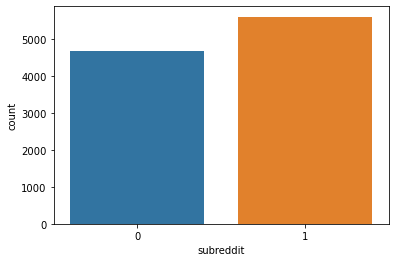

In [11]:
sns.countplot(x ='subreddit', data = df)
plt.show()

In [12]:
# Create separate subreddit for intermittentfasting
fasting = df[df['subreddit'] == 0]
fasting.head()

,title,selftext,subreddit,created_utc,post_word_count,post_length
0,Plateau sruggles,I (27F) have been intermittent fasting for abo...,0,1625589667,123,660
1,Can I still do IF/OMAD now that I started exer...,"I started lifting 4x/week (about 40 minutes), ...",0,1625586042,127,679
2,A new mindset,"Hello everyone,\n\n I am a mostly lurker here...",0,1625584307,182,929
3,Weekend habits are making it difficult to loos...,"Hi everyone,\n\nI have been doing IF (16:8) fo...",0,1625582039,110,569
4,Are these times acceptable for IF?,"So, due to loss of employment, family has take...",0,1625582007,167,806


In [13]:
# Create separate subreddit for keto
keto = df[df['subreddit'] == 1]
keto.head()

,title,selftext,subreddit,created_utc,post_word_count,post_length
4688,Deficit calories - how much is recommended,I know that it conjunction with keto we need t...,1,1614835856,46,247
4689,Share your favorite Keto-Friendly noodles/pasta!,What your guys favorite keto-friendly noodles?...,1,1614834758,64,358
4690,Is there anything wrong with having popcorn?,The Act II butter lovers box says a cup popped...,1,1614832038,49,227
4691,Having a horrible face fat issue,When I was in my early teens I gained an extre...,1,1614830826,113,565
4692,"NSV I fit into my ""goal clothes""",Gosh please never do that to yourself. Don't b...,1,1614829213,246,1320


In [14]:
# Function for plotting the distributions of word count and post lengths
def plot_length_distributions(df):
    plt.tight_layout()
    plt.figure(figsize = (8,6));
    df['post_word_count'].hist()
    plt.axvline(df['post_word_count'].mean(), color = 'orange',  lw = 5)
    plt.title('Distribution of Posts by Word Count',fontsize = 18)
    plt.xlabel('Word Count',fontsize = 16);
    plt.ylabel('Frequency',fontsize=16);

    plt.figure(figsize = (8,6));
    df['post_length'].hist()
    plt.axvline(df['post_length'].mean(), color = 'orange',  lw = 5)
    plt.title('Distribution of Posts by Character Length',fontsize = 18)
    plt.xlabel('Character Length',fontsize = 16);
    plt.ylabel('Frequency',fontsize=16);

<Figure size 432x288 with 0 Axes>

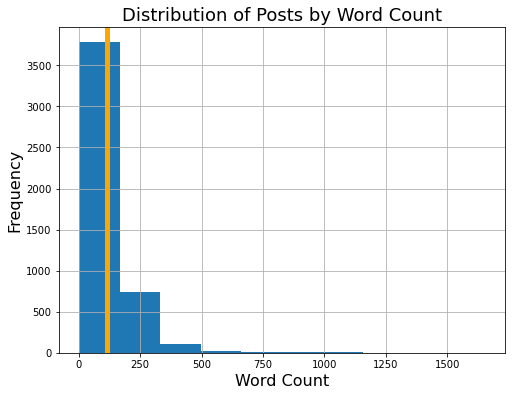

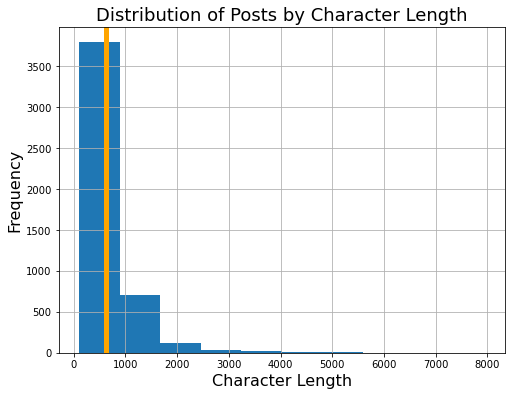

In [15]:
plot_length_distributions(fasting);

In [16]:
fasting['post_word_count'].mean()

116.51706484641639

In [17]:
fasting['post_length'].mean()

618.4010238907849

<Figure size 432x288 with 0 Axes>

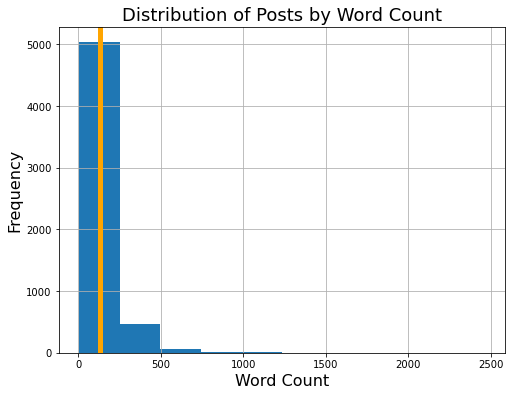

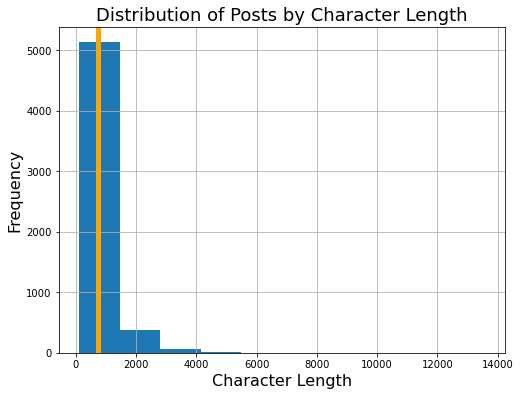

In [18]:
plot_length_distributions(keto);

In [19]:
keto['post_word_count'].mean()

133.28168511245983

In [20]:
keto['post_length'].mean()

724.1888611210283

EDA:

Class distribution: There are more intermittent fasting posts with class 0 than keto diet posts with class 1. We can say that the dataset is relatively balanced with 46% of intermittent fasting posts and 56% of keto diet posts. Since the data is balanced, we won’t be applying data-balancing techniques like SMOTE while building the model

Missing values: There are no missing values in the selftext column.

Number of words in subreddit: The average number of words in intermittent fasting is 118 as compared to an average of 132 words in a keto reddit.

Number of characters in subreddit: The average number of character length in intermittent fasting is 626 as compared to an average of 721 characters in a keto subreddit. 

Both subreddits have quite similar word count and charater length.

## Text EDA Before Pre-processing

In [21]:
def plot_top_words(subreddit_name, subreddit_num, title, n_min, n_max, n_words):
    X = df[df['subreddit'] == subreddit_num][title]
    cvec = CountVectorizer(ngram_range = (n_min,n_max), stop_words='english').fit(X)
    X = cvec.transform(X)
    X_cvec = pd.DataFrame(X.todense(), columns = cvec.get_feature_names_out())
    fsize = 12
    plt.figure(figsize = (6,6))
    X_cvec.sum().sort_values(ascending = False).head(n_words).plot(kind = 'barh');
    plt.title(f'Top words in {subreddit_name}', fontsize = fsize)
    plt.xlabel('Number of occurrences', fontsize = fsize)
    plt.xticks(fontsize = fsize)
    plt.yticks(fontsize = fsize)
    plt.tight_layout()

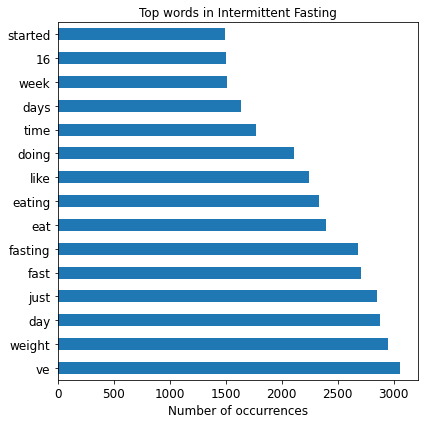

In [22]:
plot_top_words('Intermittent Fasting', 0, 'selftext', 1, 1, 15)

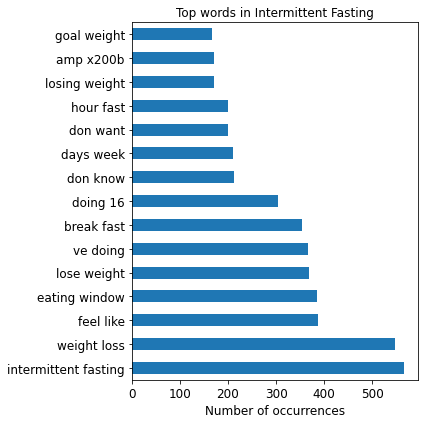

In [23]:
plot_top_words('Intermittent Fasting', 0, 'selftext', 2, 2, 15)

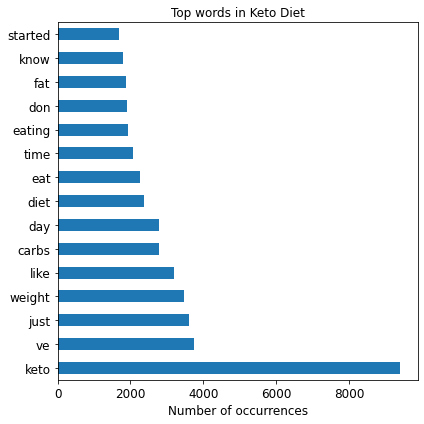

In [24]:
plot_top_words('Keto Diet', 1, 'selftext', 1, 1, 15)

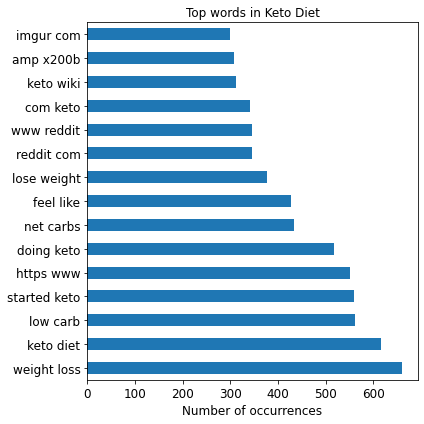

In [25]:
plot_top_words('Keto Diet', 1, 'selftext', 2, 2, 15)

Before text pre-processing, we realised that our top 15 words contain words such as 'www reddit', 'reddit com', 'https www', com keto', 'amp 200b', 've' and etc. Those words do not help us in term on understanding the content of the posts and also for model to learn the key information. Therefore, before we move to model building, we need to preprocess our text. 

## Text Pre-processing

We preprocess our text dataset by removing punctuations & special characters, cleaning texts, removing stop words, and applying lemmatization/stemming. 

### Punctuation Removal

In [26]:
#defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
df['text_no_punc']= df['selftext'].apply(lambda x:remove_punctuation(x))
df.head()

,title,selftext,subreddit,created_utc,post_word_count,post_length,text_no_punc
0,Plateau sruggles,I (27F) have been intermittent fasting for abo...,0,1625589667,123,660,I 27F have been intermittent fasting for about...
1,Can I still do IF/OMAD now that I started exer...,"I started lifting 4x/week (about 40 minutes), ...",0,1625586042,127,679,I started lifting 4xweek about 40 minutes as w...
2,A new mindset,"Hello everyone,\n\n I am a mostly lurker here...",0,1625584307,182,929,Hello everyone\n\n I am a mostly lurker here ...
3,Weekend habits are making it difficult to loos...,"Hi everyone,\n\nI have been doing IF (16:8) fo...",0,1625582039,110,569,Hi everyone\n\nI have been doing IF 168 for al...
4,Are these times acceptable for IF?,"So, due to loss of employment, family has take...",0,1625582007,167,806,So due to loss of employment family has taken ...


### Lowering the text

In [27]:
df['lower_text']= df['text_no_punc'].apply(lambda x: x.lower())

### Stopwords Removal

In [28]:
stop = stopwords.words('english')

In [29]:
df['clean_text'] = df['lower_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [30]:
df.head()

,title,selftext,subreddit,created_utc,post_word_count,post_length,text_no_punc,lower_text,clean_text
0,Plateau sruggles,I (27F) have been intermittent fasting for abo...,0,1625589667,123,660,I 27F have been intermittent fasting for about...,i 27f have been intermittent fasting for about...,27f intermittent fasting 2 months starting wei...
1,Can I still do IF/OMAD now that I started exer...,"I started lifting 4x/week (about 40 minutes), ...",0,1625586042,127,679,I started lifting 4xweek about 40 minutes as w...,i started lifting 4xweek about 40 minutes as w...,started lifting 4xweek 40 minutes well taking ...
2,A new mindset,"Hello everyone,\n\n I am a mostly lurker here...",0,1625584307,182,929,Hello everyone\n\n I am a mostly lurker here ...,hello everyone\n\n i am a mostly lurker here ...,hello everyone mostly lurker reddit first id l...
3,Weekend habits are making it difficult to loos...,"Hi everyone,\n\nI have been doing IF (16:8) fo...",0,1625582039,110,569,Hi everyone\n\nI have been doing IF 168 for al...,hi everyone\n\ni have been doing if 168 for al...,hi everyone 168 almost 3 years remained consis...
4,Are these times acceptable for IF?,"So, due to loss of employment, family has take...",0,1625582007,167,806,So due to loss of employment family has taken ...,so due to loss of employment family has taken ...,due loss employment family taken bother trying...


In [31]:
# Function for lemmatizing
def lemmatize_text(text):

    # split into words
    split_text = text.split()

    # instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()

    # lemmatize and rejoin
    return ' '.join([lemmatizer.lemmatize(word) for word in split_text])

In [32]:
def stem_text(text):

    # split into words
    split_text = text.split()
    
    # instantiate stemmer
    stemmer = PorterStemmer()

    # stem and rejoin
    return ' '.join([stemmer.stem(word) for word in split_text])

In [33]:
df['cleantext_lemm'] = df['clean_text'].apply(lemmatize_text)
df['cleantext_stem'] = df['clean_text'].apply(stem_text)

In [34]:
pd.options.display.max_colwidth = 400
df.head()

,title,selftext,subreddit,created_utc,post_word_count,post_length,text_no_punc,lower_text,clean_text,cleantext_lemm,cleantext_stem
0,Plateau sruggles,"I (27F) have been intermittent fasting for about 2 months. My starting weight was about 145lbs. The first week I did 14:8 and I lost 5 lbs. I didn't change any other habits. I hit a plateau partway through the 2nd week. I've been stuck around 135 lbs. I increased my IF to 18:6 and amped up my workout plan by adding longer, more intense cardio sessions and mixing in some strength training. It's...",0,1625589667,123,660,I 27F have been intermittent fasting for about 2 months My starting weight was about 145lbs The first week I did 148 and I lost 5 lbs I didnt change any other habits I hit a plateau partway through the 2nd week Ive been stuck around 135 lbs I increased my IF to 186 and amped up my workout plan by adding longer more intense cardio sessions and mixing in some strength training Its been a few wee...,i 27f have been intermittent fasting for about 2 months my starting weight was about 145lbs the first week i did 148 and i lost 5 lbs i didnt change any other habits i hit a plateau partway through the 2nd week ive been stuck around 135 lbs i increased my if to 186 and amped up my workout plan by adding longer more intense cardio sessions and mixing in some strength training its been a few wee...,27f intermittent fasting 2 months starting weight 145lbs first week 148 lost 5 lbs didnt change habits hit plateau partway 2nd week ive stuck around 135 lbs increased 186 amped workout plan adding longer intense cardio sessions mixing strength training weeks since made changes im still seeing weight changes im wondering anyone provide advice words encouragement im starting get discouraged feel...,27f intermittent fasting 2 month starting weight 145lbs first week 148 lost 5 lb didnt change habit hit plateau partway 2nd week ive stuck around 135 lb increased 186 amped workout plan adding longer intense cardio session mixing strength training week since made change im still seeing weight change im wondering anyone provide advice word encouragement im starting get discouraged feel like loo...,27f intermitt fast 2 month start weight 145lb first week 148 lost 5 lb didnt chang habit hit plateau partway 2nd week ive stuck around 135 lb increas 186 amp workout plan ad longer intens cardio session mix strength train week sinc made chang im still see weight chang im wonder anyon provid advic word encourag im start get discourag feel like look fit scale wont budg
1,Can I still do IF/OMAD now that I started exercising intensely?,"I started lifting 4x/week (about 40 minutes), as well as taking a lot of martial arts classes. On monday for example I had nearly 3 hours of exercising in total (2 MA + lift).\n\nI've only just started, and so far I've been sticking to my IF/OMAD routine where I skip breakfast and only eat lunch. Which means I was on a long fast for some of those exercises. And I still felt fine.\n\nSo my ques...",0,1625586042,127,679,I started lifting 4xweek about 40 minutes as well as taking a lot of martial arts classes On monday for example I had nearly 3 hours of exercising in total 2 MA lift\n\nIve only just started and so far Ive been sticking to my IFOMAD routine where I skip breakfast and only eat lunch Which means I was on a long fast for some of those exercises And I still felt fine\n\nSo my question is can I st...,i started lifting 4xweek about 40 minutes as well as taking a lot of martial arts classes on monday for example i had nearly 3 hours of exercising in total 2 ma lift\n\nive only just started and so far ive been sticking to my ifomad routine where i skip breakfast and only eat lunch which means i was on a long fast for some of those exercises and i still felt fine\n\nso my question is can i st...,started lifting 4xweek 40 minutes well taking lot martial arts classes monday example nearly 3 hours exercising total 2 lift ive started far ive sticking ifomad routine s

Checking if text are clean after processing: 

In [35]:
df[['selftext', 'cleantext_lemm', 'cleantext_stem']]

,selftext,cleantext_lemm,cleantext_stem
0,"I (27F) have been intermittent fasting for about 2 months. My starting weight was about 145lbs. The first week I did 14:8 and I lost 5 lbs. I didn't change any other habits. I hit a plateau partway through the 2nd week. I've been stuck around 135 lbs. I increased my IF to 18:6 and amped up my workout plan by adding longer, more intense cardio sessions and mixing in some strength training. It's...",27f intermittent fasting 2 month starting weight 145lbs first week 148 lost 5 lb didnt change habit hit plateau partway 2nd week ive stuck around 135 lb increased 186 amped workout plan adding longer intense cardio session mixing strength training week since made change im still seeing weight change im wondering anyone provide advice word encouragement im starting get discouraged feel like loo...,27f intermitt fast 2 month start weight 145lb first week 148 lost 5 lb didnt chang habit hit plateau partway 2nd week ive stuck around 135 lb increas 186 amp workout plan ad longer intens cardio session mix strength train week sinc made chang im still see weight chang im wonder anyon provid advic word encourag im start get discourag feel like look fit scale wont budg
1,"I started lifting 4x/week (about 40 minutes), as well as taking a lot of martial arts classes. On monday for example I had nearly 3 hours of exercising in total (2 MA + lift).\n\nI've only just started, and so far I've been sticking to my IF/OMAD routine where I skip breakfast and only eat lunch. Which means I was on a long fast for some of those exercises. And I still felt fine.\n\nSo my ques...",started lifting 4xweek 40 minute well taking lot martial art class monday example nearly 3 hour exercising total 2 lift ive started far ive sticking ifomad routine skip breakfast eat lunch mean long fast exercise still felt fine question stick usual routine ive following year even though im exercising 68 hour eating interval 1618 hour fasting even one meal day put hold eat 34 meal day includin...,start lift 4xweek 40 minut well take lot martial art class monday exampl nearli 3 hour exercis total 2 lift ive start far ive stick ifomad routin skip breakfast eat lunch mean long fast exercis still felt fine question stick usual routin ive follow year even though im exercis 68 hour eat interv 1618 hour fast even one meal day put hold eat 34 meal day includ breakfast train
2,"Hello everyone,\n\n I am a mostly lurker here in reddit. First I'd like to say that I started my IF journey almost a year ago, and saw incredible results, It is the first time I am able to, without external influence (ie. injury, diet imposition by SO, etc.) to lose weight in a consistent fashion.\n\n Ok, on to the topic. I saw a fat person waking by and surprised myself by thinking somethin...",hello everyone mostly lurker reddit first id like say started journey almost year ago saw incredible result first time able without external influence ie injury diet imposition etc lose weight consistent fashion ok topic saw fat person waking surprised thinking something along line could bet surprise came would resent fat person would like see one around ban worse projecting resented didnt wan...,hello everyon mostli lurker reddit first id like say start journey almost year ago saw incred result first time abl without extern influenc ie injuri diet imposit etc lose weight consist fashion ok topic saw fat person wake surpris think someth along line could bet surpris came would resent fat person would like see one around ban wors project resent didnt want around fat peopl remind new mind...
3,"Hi everyone,\n\nI have been doing IF (16:8) for almost 3 years. I have remained consistent in terms of weight (138-141lbs) in these 3 years. I am 5' 5.5"". Recently I started 20:4 to push my metabolism a little. I lost my weight from 141-140 in about a week ish. I have strated to eat low-carb diet to help me with fasting. I am fairly good on the weekdays. However I want to enjoy my weekend and..."

## Text EDA After Pre-processing

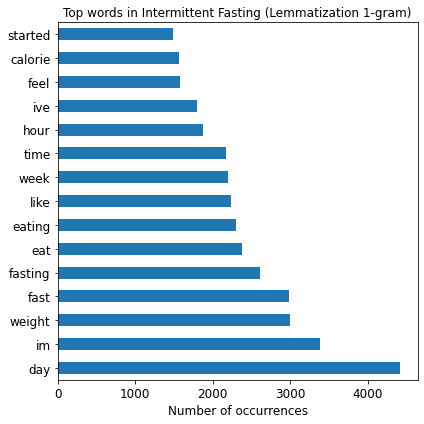

In [36]:
plot_top_words('Intermittent Fasting (Lemmatization 1-gram)', 0, 'cleantext_lemm', 1, 1, 15)

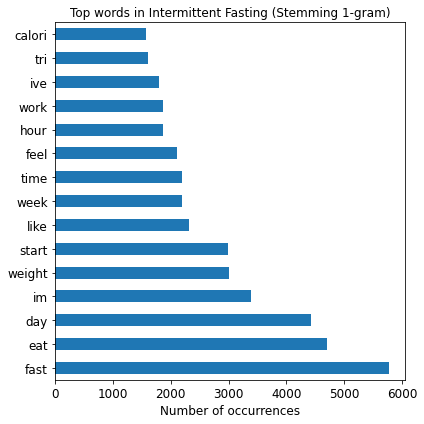

In [37]:
plot_top_words('Intermittent Fasting (Stemming 1-gram)', 0, 'cleantext_stem', 1, 1, 15)

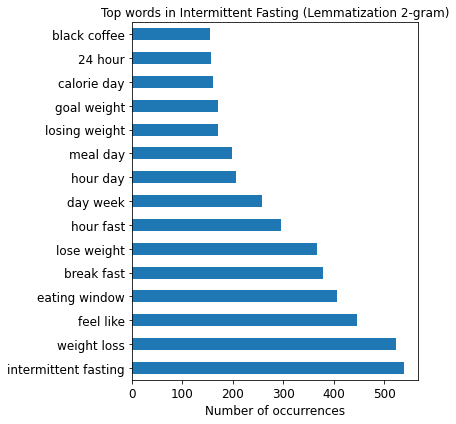

In [38]:
plot_top_words('Intermittent Fasting (Lemmatization 2-gram)', 0, 'cleantext_lemm', 2, 2, 15)

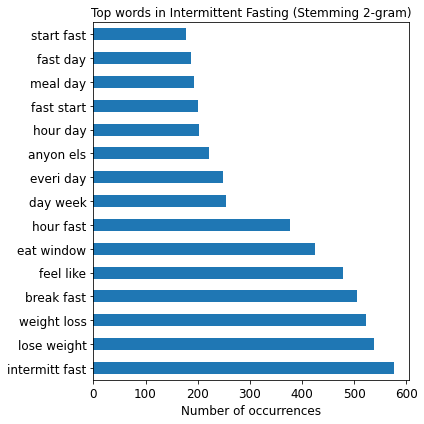

In [39]:
plot_top_words('Intermittent Fasting (Stemming 2-gram)', 0, 'cleantext_stem', 2, 2, 15)

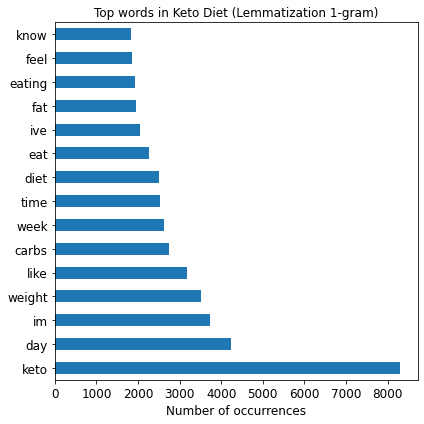

In [40]:
plot_top_words('Keto Diet (Lemmatization 1-gram)', 1, 'cleantext_lemm', 1, 1, 15)

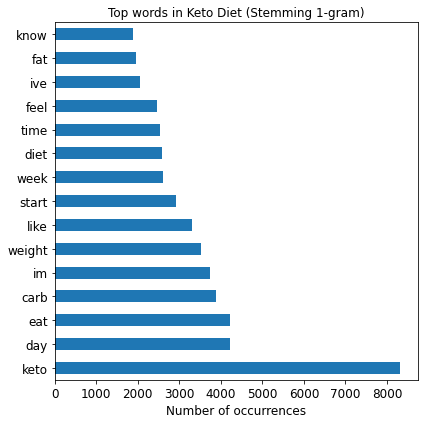

In [41]:
plot_top_words('Keto Diet (Stemming 1-gram)', 1, 'cleantext_stem', 1, 1, 15)

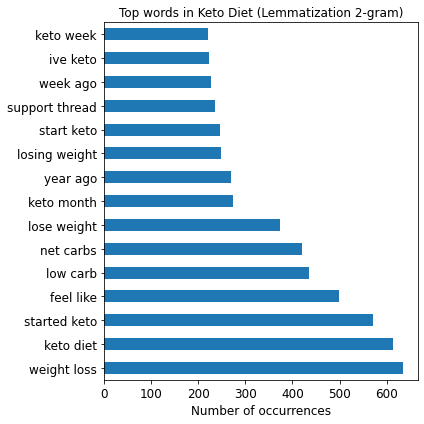

In [42]:
plot_top_words('Keto Diet (Lemmatization 2-gram)', 1, 'cleantext_lemm', 2, 2, 15)

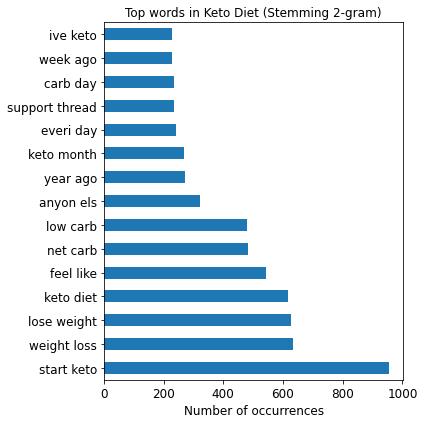

In [43]:
plot_top_words('Keto Diet (Stemming 2-gram)', 1, 'cleantext_stem', 2, 2, 15)

After lemmatizating, the top keyword that we get for class 0 (intermittent fasting) are 'day' and 'fast', while we get the most keyword of 'keto' and 'weight loss' for class 1 (keto diet). 

After stemming, the top keyword that we get for class 0 (intermittent fasting) are 'fast' and 'intermittent fast', while we get most keyword of 'keto' and 'start keto' for class 1 (keto diet). 

In the below analysis, we extract post that consist of word of 'keto' and 'intermittent fast' as these keywords appear as the most frequent after lemmatizing and stemming.  

In [44]:
[status for status in df['selftext'] if 'keto' in status.lower()][:10]

[" First time on this sub!\n\nSo I have a friend flying in from outta state and I know my entire group of friends 10 of us are going to go out to dinner on Wed (its currently Monday arvo). We are biiiiig foodies usually, but I'm in week 2 of a strict, buckle down keto for 12 weeks. Normally I'd just break and eat whatever and be back on keto the next day as this kinda night is rare. BUT there's a wedding coming! I dont want to break, but I also cant weigh and count calories.... So while keeping it keto I'm going to just eat the portion given and hope for the best.\n\nNow here is the issue, I'm currently on a 40+hr fast, started last night Sun at 5pm, its currently Mon 3pm. I had planned to go as long as I felt good until Tuesday night, since I enjoy playing with fasts, however my max has been 40hrs.\n\n.1. Do I swap it to 3x 24hr fasts by eating at 5pm today and tomorrow then having the special dinner Wed\n\nOR\n\n2. Do I stick with this 40hr fast, eat my usual 12pm lunch on Wed and th

In [45]:
[status for status in df['selftext'] if 'intermittent fast' in status.lower()][:10]

["I (27F) have been intermittent fasting for about 2 months. My starting weight was about 145lbs. The first week I did 14:8 and I lost 5 lbs. I didn't change any other habits. I hit a plateau partway through the 2nd week. I've been stuck around 135 lbs. I increased my IF to 18:6 and amped up my workout plan by adding longer, more intense cardio sessions and mixing in some strength training. It's been a few weeks since I made those changes and I'm still not seeing any weight changes. I'm wondering if anyone can provide some advice or words of encouragement for me. I'm starting to get discouraged. I do feel like I look more 'fit' but the scale won't budge!",
 'So, due to loss of employment, family has taken me in. Not to be a bother I am trying to use as little as I can before getting back on my feet. My brother makes lunch at 1 PM and the family eats together at 8 PM. So to my understanding of how Intermittent fasting works is, if I wake up at 9 AM, eat first meal at 1 PM and the second

My impression after reading fews posts that contain words of 'keto' and 'interminttent fast' are many posters are actually on reddit to seek for advices or suggestions to help on their process on interminttent fasting of keto. Few people share their sucess and health improvement during the process while some other people actually face health issue during the process of weight loss. 

## Sentiment Analysis

In sentiment analysis, we select text after lemmatization for analysis as lemmatization reduce the similar words into its base word which have meaning.

In [46]:
data = df[['cleantext_lemm']].copy()
data.head()

,cleantext_lemm
0,27f intermittent fasting 2 month starting weight 145lbs first week 148 lost 5 lb didnt change habit hit plateau partway 2nd week ive stuck around 135 lb increased 186 amped workout plan adding longer intense cardio session mixing strength training week since made change im still seeing weight change im wondering anyone provide advice word encouragement im starting get discouraged feel like loo...
1,started lifting 4xweek 40 minute well taking lot martial art class monday example nearly 3 hour exercising total 2 lift ive started far ive sticking ifomad routine skip breakfast eat lunch mean long fast exercise still felt fine question stick usual routine ive following year even though im exercising 68 hour eating interval 1618 hour fasting even one meal day put hold eat 34 meal day includin...
2,hello everyone mostly lurker reddit first id like say started journey almost year ago saw incredible result first time able without external influence ie injury diet imposition etc lose weight consistent fashion ok topic saw fat person waking surprised thinking something along line could bet surprise came would resent fat person would like see one around ban worse projecting resented didnt wan...
3,hi everyone 168 almost 3 year remained consistent term weight 138141lbs 3 year 5 55 recently started 204 push metabolism little lost weight 141140 week ish strated eat lowcarb diet help fasting fairly good weekday however want enjoy weekend go little crazy ok friday eve saturday believe hampering weight loss havent lost anything week folk stay accountable weekend
4,due loss employment family taken bother trying use little getting back foot brother make lunch 1 pm family eats together 8 pm understanding intermittent fasting work wake 9 eat first meal 1 pm second meal longer 8 hour first meal mean hunger pain ie skip breakfast morning start eating window lunch read one meal middle first last meal provided window still 8 hour want small expense possible hop...


In [47]:
# create the method to get subjectivity
# subjectivity tells us how subjective or opinionated the text is.
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# create the method to get the polarity
# polarity tells how positive or negative the text is.
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [48]:
# Create columns subjectivity and polarity.
data['Subjectivity'] = data['cleantext_lemm'].apply(get_subjectivity)
data['Polarity'] = data['cleantext_lemm'].apply(get_polarity)

In [49]:
data.head()

,cleantext_lemm,Subjectivity,Polarity
0,27f intermittent fasting 2 month starting weight 145lbs first week 148 lost 5 lb didnt change habit hit plateau partway 2nd week ive stuck around 135 lb increased 186 amped workout plan adding longer intense cardio session mixing strength training week since made change im still seeing weight change im wondering anyone provide advice word encouragement im starting get discouraged feel like loo...,0.322222,0.141667
1,started lifting 4xweek 40 minute well taking lot martial art class monday example nearly 3 hour exercising total 2 lift ive started far ive sticking ifomad routine skip breakfast eat lunch mean long fast exercise still felt fine question stick usual routine ive following year even though im exercising 68 hour eating interval 1618 hour fasting even one meal day put hold eat 34 meal day includin...,0.468750,0.020417
2,hello everyone mostly lurker reddit first id like say started journey almost year ago saw incredible result first time able without external influence ie injury diet imposition etc lose weight consistent fashion ok topic saw fat person waking surprised thinking something along line could bet surprise came would resent fat person would like see one around ban worse projecting resented didnt wan...,0.497944,0.313312
3,hi everyone 168 almost 3 year remained consistent term weight 138141lbs 3 year 5 55 recently started 204 push metabolism little lost weight 141140 week ish strated eat lowcarb diet help fasting fairly good weekday however want enjoy weekend go little crazy ok friday eve saturday believe hampering weight loss havent lost anything week folk stay accountable weekend,0.500000,0.109375
4,due loss employment family taken bother trying use little getting back foot brother make lunch 1 pm family eats together 8 pm understanding intermittent fasting work wake 9 eat first meal 1 pm second meal longer 8 hour first meal mean hunger pain ie skip breakfast morning start eating window lunch read one meal middle first last meal provided window still 8 hour want small expense possible hop...,0.301944,0.025000


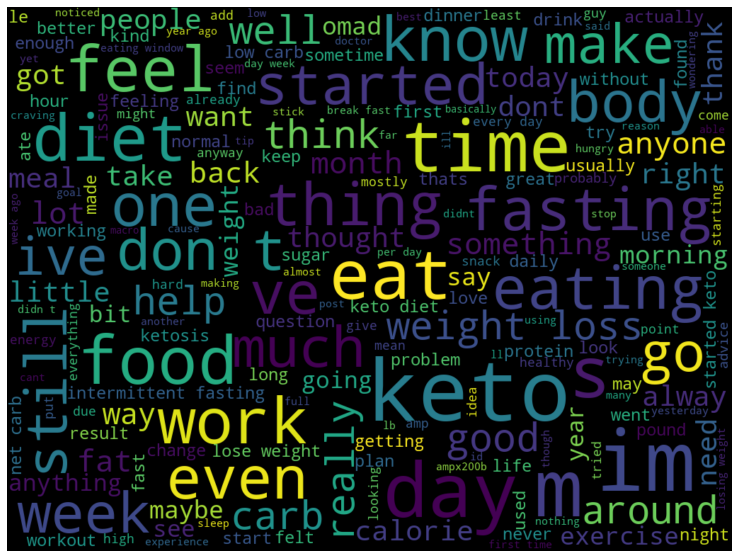

In [50]:
# visualize data with word cloud
all_comments = ' '.join ( [comments for comments in data['cleantext_lemm']])
word_cloud = WordCloud(width=1024, height=768, random_state=21, max_font_size = 120).generate(all_comments)

plt.figure( figsize=(20,10) )
plt.imshow(word_cloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [51]:
# Method to label neg., neutral and positive comments
def get_analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

data['Analysis'] = data['Polarity'].apply(get_analysis)

In [52]:
data.head()

,cleantext_lemm,Subjectivity,Polarity,Analysis
0,27f intermittent fasting 2 month starting weight 145lbs first week 148 lost 5 lb didnt change habit hit plateau partway 2nd week ive stuck around 135 lb increased 186 amped workout plan adding longer intense cardio session mixing strength training week since made change im still seeing weight change im wondering anyone provide advice word encouragement im starting get discouraged feel like loo...,0.322222,0.141667,Positive
1,started lifting 4xweek 40 minute well taking lot martial art class monday example nearly 3 hour exercising total 2 lift ive started far ive sticking ifomad routine skip breakfast eat lunch mean long fast exercise still felt fine question stick usual routine ive following year even though im exercising 68 hour eating interval 1618 hour fasting even one meal day put hold eat 34 meal day includin...,0.468750,0.020417,Positive
2,hello everyone mostly lurker reddit first id like say started journey almost year ago saw incredible result first time able without external influence ie injury diet imposition etc lose weight consistent fashion ok topic saw fat person waking surprised thinking something along line could bet surprise came would resent fat person would like see one around ban worse projecting resented didnt wan...,0.497944,0.313312,Positive
3,hi everyone 168 almost 3 year remained consistent term weight 138141lbs 3 year 5 55 recently started 204 push metabolism little lost weight 141140 week ish strated eat lowcarb diet help fasting fairly good weekday however want enjoy weekend go little crazy ok friday eve saturday believe hampering weight loss havent lost anything week folk stay accountable weekend,0.500000,0.109375,Positive
4,due loss employment family taken bother trying use little getting back foot brother make lunch 1 pm family eats together 8 pm understanding intermittent fasting work wake 9 eat first meal 1 pm second meal longer 8 hour first meal mean hunger pain ie skip breakfast morning start eating window lunch read one meal middle first last meal provided window still 8 hour want small expense possible hop...,0.301944,0.025000,Positive


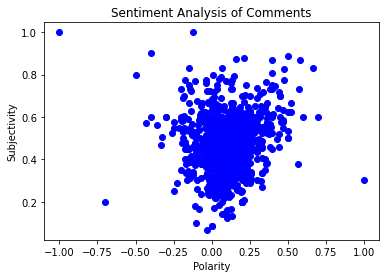

<Figure size 1440x720 with 0 Axes>

In [53]:
# Plot the polarity and subj.

for i in range(0, int((data.shape[0])/10)):
    plt.scatter(data['Polarity'][i], data['Subjectivity'][i], color='Blue')
    
plt.title('Sentiment Analysis of Comments')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.figure( figsize=(20,10) )
plt.show()

In [54]:
positive_comments = data[data.Analysis == 'Positive']
positive_comments = positive_comments['cleantext_lemm']

round( (positive_comments.shape[0] / data.shape[0]) *100, 1 )

75.1

In [55]:
neg_comments = data[data.Analysis == 'Negative']
neg_comments = neg_comments['cleantext_lemm']

round( (neg_comments.shape[0] / data.shape[0]) *100, 1 )

22.1

In [56]:
neutral_comments =  data[data.Analysis == 'Neutral']
neutral_comments = neutral_comments['cleantext_lemm']

round( (neutral_comments.shape[0] / data.shape[0]) *100, 1 )

2.8

Generally, the sentiment in the comments are positive, which possess 75.1% from the whole data we collected. There are 22.1% are negative comments and only 2.8% are neutral comments.

## Export Dataset for Modeling

In [57]:
df.drop(columns = ['text_no_punc', 'lower_text', 'clean_text', 'cleantext_lemm'], inplace = True)

In [58]:
df.to_csv('data/subreddit_stem_cleaned.csv', index=False)

Lemmatization and stemming did not make much differences in the top occurring unigram and bigrams. Stemming tend to return some words that do not convey much meaning while lemmatizing is usually the more correct and precise way of handling things from a grammatical point of view.  In the industry, generally, stemming is preferred over lemmatization because of the benefit of streamlining number of columns for our downstream modeling task. Therefore, we will remain 'cleantext_stem' for our downsream modeling process.